In [174]:
from memoization import memoize_to_folder

In [175]:
from scapy.all import *
import sys
import numpy as np
import os
import dpkt

KEYLEN=8

@memoize_to_folder('memo/pcaps2')
def read_pcap(out_dir):
    pcfs = [os.path.join(out_dir, 'moongen', 'moongen.pcap')]
    
    n_sets = [0]
    n_misses = [0]
    n_gets = [0]
    n_values = [0]
    gets = defaultdict(list)
    vals = defaultdict(list)
    
    for pcf in pcfs:
        f = open(pcf, 'rb')
        print("Reading {}".format(pcf))
        pcap=dpkt.pcap.Reader(f)
        for ts, buf in pcap:
            try:
                eth=dpkt.ethernet.Ethernet(buf)
                ip=eth.data
                tcp = ip.data
                spkt = tcp.data
            except Exception as e:
                print("Exception parsing packet {} : {}".format(buf, e))
                continue

            try: 
                get_start = spkt.find(b'get ')
                if get_start >= 0:
                    key = spkt[:2] + spkt[get_start+4:get_start+4+KEYLEN]
                    gets[key].append(ts)
                    n_gets[0] += 1
                    if n_gets[0] % 5000 == 0:
                        print('{}th get'.format(n_gets[0]))
                    continue
                val_start = spkt.find(b'VALUE ')
                if val_start >= 0:
                    key = spkt[:2] + spkt[val_start+6:val_start+6+KEYLEN]
                    vals[key].append(ts)
                    n_values[0] += 1
                    if n_values[0] % 5000 == 0:
                        print("{}th value".format(n_values[0]))
                    continue
                if b'set ' in spkt:
                    n_sets[0] += 1
                    if n_sets[0] % 2000 == 0:
                        print('{}th set'.format(n_sets[0]))
                elif b'STORED' in spkt:
                    continue
                elif b'END' in spkt:
                    n_misses[0] += 1
                else:
                    print('Unknown packet load: {}'.format(spkt))
            except AttributeError as e:
                print("Exception reading payload from {}: {}".format(buf, e))
        
    print("Got {} sets".format(n_sets[0]))
    print("Got {} values".format(n_values[0]))
    
    print("Got {} explicit misses".format(n_misses[0]))
    print("Read pcap file")
    return gets, vals

def read_rate_file(out_dir):
    ratefile = os.path.join(out_dir, 'pktgen.log')
    with open(ratefile) as f:
        ratestr = f.read()
    if not ratestr.startswith('Rate: '):
        raise Exception("Could not read rate string")
    rate = int(ratestr.strip("Rate: "))
    return rate

def read_experiment(directory):
    print( "Reading from directory {}".format(directory))
    return read_pcap(directory), read_rate_file(directory)

In [176]:
import itertools

def best_drop_tds(vtimes, gtimes, both_drops=0):
    vtimes = np.array(vtimes)
    gtimes = np.array(gtimes)
    lendiff = len(gtimes) - len(vtimes)
    maxlen = max(len(gtimes), len(vtimes))
    minlen = min(len(gtimes), len(vtimes))
    
    n_gdrops = max(-lendiff, 0)
    n_vdrops = max(lendiff, 0)
    
    if n_gdrops == 0 and n_vdrops == 0:
        tdiffs = vtimes - gtimes
        tds = []
        for td, gd in zip(tdiffs, gtimes):
            if not np.isnan(td) and td > 0:
                tds.append((gd, td))
        return tds        
    
    if n_gdrops != 0:
        print( "Missing GET")
        
        drop_locs = []
        max_drop = 0
        
        for n_g in range(n_gdrops):
            v_cut = vtimes[: minlen + n_g + 1]
            min_std = None
            min_std_drop_locs = None
            
            for i in range(max_drop, len(v_cut)):
                this_drop_locs = drop_locs[:]
                this_drop_locs.append(i)
                
                this_gtimes = gtimes[:]
                for drop_loc in this_drop_locs:
                    this_gtimes = np.insert(this_gtimes, drop_loc, np.nan)
                
                tdiffs = v_cut - this_gtimes
                tdiffs = tdiffs[~np.isnan(tdiffs)]
                if any(tdiffs < 0):
                    continue
                this_std = np.std(tdiffs)
                
                if min_std is None or this_std < min_std:
                    min_std = this_std
                    min_std_drop_locs = this_drop_locs
                    
            if min_std is None:
                return []
            drop_locs = min_std_drop_locs if min_std_drop_locs is not None else [0] + drop_locs
            max_drop = max(drop_locs)
    
        gdrops = gtimes[:]
        for drop_loc in drop_locs:
            gdrops = np.insert(gdrops, drop_loc, np.nan)
        tdiffs = vtimes - gdrops
        tds = []
        for td, gd in zip(tdiffs, gdrops):
            if not np.isnan(td):
                tds.append((gd, td))
        return tds

    if n_vdrops != 0:
        
        drop_locs = []
        max_drop = 0
        
        for n_v in range(n_vdrops):
            g_cut = gtimes[: minlen + n_v + 1]
            min_std = None
            min_std_drop_locs = None
            
            for i in range(max_drop, len(g_cut)):
                this_drop_locs = drop_locs[:]
                this_drop_locs.append(i)
                
                this_vtimes = vtimes[:]
                for drop_loc in this_drop_locs:
                    this_vtimes = np.insert(this_vtimes, drop_loc, np.nan)
                
                tdiffs = this_vtimes - g_cut
                tdiffs = tdiffs[~np.isnan(tdiffs)]
                if any(tdiffs < 0):
                    continue
                this_std = np.std(tdiffs)
                
                if min_std is None or this_std < min_std:
                    min_std = this_std
                    min_std_drop_locs = this_drop_locs
                    
            if min_std is None:
                return []
            drop_locs = min_std_drop_locs if min_std_drop_locs is not None else [0] + drop_locs
            max_drop = max(drop_locs)
    
        vdrops = vtimes[:]
        for drop_loc in drop_locs:
            vdrops = np.insert(vdrops, drop_loc, np.nan)
        tdiffs = vdrops - gtimes
        tds = []
        for td, vd in zip(tdiffs, vdrops):
            if not np.isnan(td):
                tds.append((vd, td))
        return tds                

def get_success_percent(gets, values):
    return float(sum(len(v) for v in values.values())) / float(sum(len(g) for g in gets.values()))

def get_tds(gets, values, threshold=None):
    print("Getting TDs")
    tds = []
    min_gtime = min(min(x) for x in gets.values())
    missing_values = []
    drops = 0
    for k, vtimes in values.items():
        if k not in gets:
            missing_values.extend(values[k])
            continue
        vtimes = np.array(vtimes)
        gtimes = np.array(gets[k])
        lendiff = len(gtimes) - len(vtimes)
        
        if lendiff != 0:
            print("{} gets and {} values".format(len(gtimes), len(vtimes)))
        
        new_tds = best_drop_tds(vtimes, gtimes)
        tds.extend(new_tds)
        
        drops += abs(len(new_tds) - max(len(vtimes), len(gtimes)))
      
    print("Missing {} gets".format(len(missing_values)))
    print("{} drops noticed".format(drops))
    print("{} drops total".format(sum(len(g) for g in gets.values()) - sum(len(v) for v in values.values())))
    print("{} tds".format(len(tds)))
    return np.array(tds)

def experiment_success_rate(directory):
    (gets, vals), rate = read_experiment(directory)
    apparent_rate = sum(len(g) for g in gets.values()) / float(max(max(g) for g in gets.values()) - min(min(g) for g in gets.values())) 
    return get_success_percent(gets, vals), rate, apparent_rate 

@memoize_to_folder("memo/tds")
def experiment_tds(directory):
    (gets, vals), _ = read_experiment(directory)
    
    apparent_rate = sum(len(g) for g in gets.values()) / float(max(max(g) for g in gets.values()) - min(min(g) for g in gets.values())) 
   
    return get_tds(gets, vals), apparent_rate, sum(len(g) for g in gets.values())

In [177]:
best_drop_tds([2.5,4.5,],[2., 4., 5., 6., 7.])

[(2.5, 0.5), (4.5, 0.5)]

In [178]:
import glob
import time
import re
from multiprocessing import Pool as ThreadPool 

def experiment_tds_wrapper(arg):
    start = time.time()
    try:
        print("Running {}".format(arg))
        rtn = experiment_tds(arg)
        end = time.time()
        if rtn is None:
            rtn = experiment_tds(arg, __recalculate=True)
        print("Completed {} in {}s".format(arg, end - start))
        return rtn, arg
    except Exception as e:
        print("Did not complete {}!!!! {}".format(arg, e))
        return None
        
def dictize(d):
    d = copy.deepcopy(d)
    for k in d.keys():
        if isinstance(d[k], defaultdict):
            d[k] = dictize(d[k])
    return dict(d)

def load_all_experiments(toptopdir='inputs', depth=1, poolsize=5):
    d = toptopdir
    rec_dd = lambda : defaultdict(rec_dd)
    experiments = defaultdict(rec_dd)
    
    directories = glob.glob(os.path.join(toptopdir, '*'))
    for i in range(depth):
        new_directories = []
        for subdir in directories:
            new_directories.extend(glob.glob(os.path.join(subdir, '*')))
        directories = new_directories
        
    pool = ThreadPool(poolsize)
    results = pool.map(experiment_tds_wrapper, directories)
    pool.close()
    pool.join()
    results = [ x for x in results if x is not None]
        
    for (tds, rate, ngets), directory in results:
        split_dir = directory.split('/')
        keys = []
        for part in split_dir:
            if part not in toptopdir:
                for key in keys:
                    part = part.replace(key, '')
                    part = part.strip('_')
                keys.append(part)
        
        experiment = experiments
        for key in keys[:-1]:
            experiment = experiment[key]
        experiment[keys[-1]] = rate, tds, ngets
    
    return dictize(experiments)
            
    #experiments[subsub][subdir] = load_all_experiments(d)

    #return dict(experiments)

In [179]:
def apparent_rate(exp):
    tss = exp[0][:,0]
    diff = max(tss) - min(tss)
    rate = float(exp[2]) / diff
    return rate

def success_rate(exp):
    tss = exp[0][:,0]
    diff = max(tss) - min(tss)
    rate = float(len(tss)) / diff
    return rate

def plot_apparent_rate(exps):
    x = []
    y = []
    for exp in exps:
        x.append(exp[1])
        y.append(apparent_rate(exp))
    plt.plot(x,y, '.-')

In [180]:
# load_all_experiments('../new_output/upset_booster_misses_fixed_.1', depth=0, poolsize=8)

In [234]:

upset_booster_only_files = (
    '../output/booster_alone/upset_booster_alone_2_0.10',
    '../output/booster_alone/upset_booster_alone_1_0.25',
    '../output/booster_alone/upset_booster_alone_1_0.50',
    '../output/booster_alone/upset_booster_alone_1_0.75',
    '../output/booster_alone/upset_booster_alone_1_1.00',
    '../output/booster_alone/upset_booster_alone_1_1.25',
    '../output/booster_alone/upset_booster_alone_1_1.50',
    '../output/booster_alone/upset_booster_alone_1_1.75',
    '../output/booster_alone/upset_booster_alone_2_2.00',
#      '../new_output/upset_booster_alone/upset_booster_alone_1_2.00',
#     '../output/booster_alone/upset_booster_alone_1_2.50',
#     '../output/booster_alone/upset_booster_alone_1_2.75',
#     '../output/booster_alone/upset_booster_alone_1_3.00',
    
)

upset_booster_only = [experiment_tds(x) for x in upset_booster_only_files]
upset_booster_only_success = [experiment_success_rate(x) for x in upset_booster_only_files]

Loading from memo/tds/experiment_tds__directory-outputbooster_aloneupset_booster_alone_2_010.pickle
:: Cached stdout:
 :: Reading from directory ../output/booster_alone/upset_booster_alone_2_0.10 :: 
 :: Reading ../output/booster_alone/upset_booster_alone_2_0.10/moongen/moongen.pcap :: 
 :: 2000th set :: 
 :: 4000th set :: 
 :: 6000th set :: 
 :: 8000th set :: 
 :: 10000th set :: 
 :: 5000th get :: 
 :: 5000th value :: 
 :: 10000th get :: 
 :: 10000th value :: 
 :: 15000th get :: 
 :: 15000th value :: 
 :: 20000th get :: 
 :: 20000th value :: 
 :: 25000th get :: 
 :: 25000th value :: 
 :: 30000th get :: 
 :: 30000th value :: 
 :: 35000th get :: 
 :: 35000th value :: 
 :: 40000th get :: 
 :: 40000th value :: 
 :: 45000th get :: 
 :: 45000th value :: 
 :: 50000th get :: 
 :: 50000th value :: 
 :: Unknown packet load: b'\x01\x01\x06\x00\xed\x15\x1a\xa9\xf5\xe5\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\xc9?)\xd1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\

Reading from directory ../output/booster_alone/upset_booster_alone_1_0.25
Loading from memo/pcaps2/read_pcap__out_dir-outputbooster_aloneupset_booster_alone_1_025.pickle
Reading from directory ../output/booster_alone/upset_booster_alone_1_0.50
Loading from memo/pcaps2/read_pcap__out_dir-outputbooster_aloneupset_booster_alone_1_050.pickle
Reading from directory ../output/booster_alone/upset_booster_alone_1_0.75
Loading from memo/pcaps2/read_pcap__out_dir-outputbooster_aloneupset_booster_alone_1_075.pickle
Reading from directory ../output/booster_alone/upset_booster_alone_1_1.00
Loading from memo/pcaps2/read_pcap__out_dir-outputbooster_aloneupset_booster_alone_1_100.pickle
Reading from directory ../output/booster_alone/upset_booster_alone_1_1.25
Loading from memo/pcaps2/read_pcap__out_dir-outputbooster_aloneupset_booster_alone_1_125.pickle
Reading from directory ../output/booster_alone/upset_booster_alone_1_1.50
Loading from memo/pcaps2/read_pcap__out_dir-outputbooster_aloneupset_booster

In [206]:
upset_mcd_only_files = (
#       '../new_output/upset_mcd_alone/upset_mcd_alone_1_0.01',
#       '../new_output/upset_mcd_alone/upset_mcd_alone_1_0.02',
#       '../new_output/upset_mcd_alone/upset_mcd_alone_1_0.05',
      '../output/mcd_alone/upset_mcd_alone_1_0.10',
#       '../output/mcd_alone/upset_mcd_alone_1_0.15',
#       '../output/mcd_alone/upset_mcd_alone_1_0.20',
      '../output/mcd_alone/upset_mcd_alone_1_0.25',
#       '../output/mcd_alone/upset_mcd_alone_1_0.30',
#       '../output/mcd_alone/upset_mcd_alone_1_0.35',
#       '../output/mcd_alone/upset_mcd_alone_1_0.40',
#       '../output/mcd_alone/upset_mcd_alone_1_0.45',
      '../output/mcd_alone/upset_mcd_alone_1_0.50',
      '../output/mcd_alone/upset_mcd_alone_2_0.75',
      '../output/mcd_alone/upset_mcd_alone_2_1.00',
      '../output/mcd_alone/upset_mcd_alone_2_1.25',
      '../output/mcd_alone/upset_mcd_alone_2_1.50',
      '../output/mcd_alone/upset_mcd_alone_3_1.75',
      '../output/mcd_alone/upset_mcd_alone_3_2.00',
#       '../output/mcd_alone/upset_mcd_alone_3_2.25',
#       '../output/mcd_alone/upset_mcd_alone_3_2.50'
#       '../new_output/upset_mcd_alone/upset_mcd_alone_2_1.75',
    
)

upset_mcd_only = [experiment_tds(x) for x in upset_mcd_only_files]
upset_mcd_only_success = [experiment_success_rate(x) for x in upset_mcd_only_files]

Loading from memo/tds/experiment_tds__directory-outputmcd_aloneupset_mcd_alone_1_010.pickle
:: Cached stdout:
 :: Reading from directory ../output/mcd_alone/upset_mcd_alone_1_0.10 :: 
 :: Loading from memo/pcaps2/read_pcap__out_dir-outputmcd_aloneupset_mcd_alone_1_010.pickle :: 
 :: Getting TDs :: 
 :: Missing 0 gets :: 
 :: 0 drops noticed :: 
 :: 0 drops total :: 
 :: 50000 tds :: 

Loading from memo/tds/experiment_tds__directory-outputmcd_aloneupset_mcd_alone_1_025.pickle
:: Cached stdout:
 :: Reading from directory ../output/mcd_alone/upset_mcd_alone_1_0.25 :: 
 :: Loading from memo/pcaps2/read_pcap__out_dir-outputmcd_aloneupset_mcd_alone_1_025.pickle :: 
 :: Getting TDs :: 
 :: Missing 0 gets :: 
 :: 0 drops noticed :: 
 :: 620 drops total :: 
 :: 49380 tds :: 

Loading from memo/tds/experiment_tds__directory-outputmcd_aloneupset_mcd_alone_1_050.pickle
:: Cached stdout:
 :: Reading from directory ../output/mcd_alone/upset_mcd_alone_1_0.50 :: 
 :: Loading from memo/pcaps2/read_pcap

Reading from directory ../output/mcd_alone/upset_mcd_alone_1_0.25
Loading from memo/pcaps2/read_pcap__out_dir-outputmcd_aloneupset_mcd_alone_1_025.pickle
Reading from directory ../output/mcd_alone/upset_mcd_alone_1_0.50
Loading from memo/pcaps2/read_pcap__out_dir-outputmcd_aloneupset_mcd_alone_1_050.pickle
Reading from directory ../output/mcd_alone/upset_mcd_alone_2_0.75
Loading from memo/pcaps2/read_pcap__out_dir-outputmcd_aloneupset_mcd_alone_2_075.pickle
Reading from directory ../output/mcd_alone/upset_mcd_alone_2_1.00
Loading from memo/pcaps2/read_pcap__out_dir-outputmcd_aloneupset_mcd_alone_2_100.pickle
Reading from directory ../output/mcd_alone/upset_mcd_alone_2_1.25
Loading from memo/pcaps2/read_pcap__out_dir-outputmcd_aloneupset_mcd_alone_2_125.pickle
Reading from directory ../output/mcd_alone/upset_mcd_alone_2_1.50
Loading from memo/pcaps2/read_pcap__out_dir-outputmcd_aloneupset_mcd_alone_2_150.pickle
Reading from directory ../output/mcd_alone/upset_mcd_alone_3_1.75
Loading fr

In [187]:
booster_misses_50_50_files = (
    '../new_output/upset_booster_misses_fixed_2_.5/booster_misses_50-50_8_0.10',
    '../new_output/upset_booster_misses_fixed_2_.5/booster_misses_50-50_8_0.25',
    '../new_output/upset_booster_misses_fixed_2_.5/booster_misses_50-50_8_0.50',
    '../new_output/upset_booster_misses_fixed_2_.5/booster_misses_50-50_8_0.75',
    '../output/booster_misses_.5/fixed_misses_.5_3_1.00',
    '../output/booster_misses_.5/fixed_misses_.5_3_1.25',
    '../output/booster_misses_.5/fixed_misses_.5_3_1.50',
    '../output/booster_misses_.5/fixed_misses_.5_3_1.75',
    '../output/booster_misses_.5/fixed_misses_.5_3_2.00',
)

booster_misses_50_50 = [experiment_tds(x) for x in booster_misses_50_50_files]
booster_misses_50_50_success = [experiment_success_rate(x) for x in booster_misses_50_50_files]

Reading from directory ../new_output/upset_booster_misses_fixed_2_.5/booster_misses_50-50_8_0.10
Reading ../new_output/upset_booster_misses_fixed_2_.5/booster_misses_50-50_8_0.10/moongen/moongen.pcap
2000th set
4000th set
6000th set
8000th set
10000th set
5000th get
5000th value
10000th get
10000th value
15000th get
15000th value
20000th get
20000th value
25000th get
25000th value
30000th get
30000th value
35000th get
35000th value
40000th get
40000th value
45000th get
45000th value
50000th get
50000th value
Unknown packet load: b'\x01\x01\x06\x00\xed\x15\x1a\xa92 \x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\xc9?)\xd1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
Unknown packet load: b'\x01\x01\x06\x00\x

Reading from directory ../new_output/upset_booster_misses_fixed_2_.5/booster_misses_50-50_8_0.25
Loading from memo/pcaps2/read_pcap__out_dir--5413718516504516176.pickle
Reading from directory ../new_output/upset_booster_misses_fixed_2_.5/booster_misses_50-50_8_0.50
Loading from memo/pcaps2/read_pcap__out_dir-7174648307549415705.pickle
Reading from directory ../new_output/upset_booster_misses_fixed_2_.5/booster_misses_50-50_8_0.75
Loading from memo/pcaps2/read_pcap__out_dir-377219610987249319.pickle
Reading from directory ../output/booster_misses_.5/fixed_misses_.5_3_1.00
Loading from memo/pcaps2/read_pcap__out_dir-outputbooster_misses_5fixed_misses_5_3_100.pickle
Reading from directory ../output/booster_misses_.5/fixed_misses_.5_3_1.25
Loading from memo/pcaps2/read_pcap__out_dir-outputbooster_misses_5fixed_misses_5_3_125.pickle
Reading from directory ../output/booster_misses_.5/fixed_misses_.5_3_1.50
Loading from memo/pcaps2/read_pcap__out_dir-outputbooster_misses_5fixed_misses_5_3_150

In [201]:
booster_misses_90_10_files = (
    '../output/booster_misses_.1/fixed_misses_.1_2_0.10',
    '../output/booster_misses_.1/fixed_misses_.1_2_0.25',
    '../output/booster_misses_.1/fixed_misses_.1_2_0.50',
    '../output/booster_misses_.1/fixed_misses_.1_2_0.75',
    '../output/booster_misses_.1/fixed_misses_.1_2_1.00',
    '../output/booster_misses_.1/fixed_misses_.1_2_1.25',
    '../output/booster_misses_.1/fixed_misses_.1_2_1.50',
    '../output/booster_misses_.1/fixed_misses_.1_2_1.75',
    '../output/booster_misses_.1/fixed_misses_.1_2_2.00',
)

booster_misses_90_10 = [experiment_tds(x, __recalculate=True) for x in booster_misses_90_10_files]
booster_misses_90_10_success = [experiment_success_rate(x) for x in booster_misses_90_10_files]

Reading from directory ../output/booster_misses_.1/fixed_misses_.1_2_0.10
Loading from memo/pcaps2/read_pcap__out_dir-outputbooster_misses_1fixed_misses_1_2_010.pickle
Getting TDs
Missing 0 gets
0 drops noticed
0 drops total
50000 tds
Reading from directory ../output/booster_misses_.1/fixed_misses_.1_2_0.25
Loading from memo/pcaps2/read_pcap__out_dir-outputbooster_misses_1fixed_misses_1_2_025.pickle
Getting TDs
Missing 0 gets
0 drops noticed
0 drops total
50000 tds
Reading from directory ../output/booster_misses_.1/fixed_misses_.1_2_0.50
Loading from memo/pcaps2/read_pcap__out_dir-outputbooster_misses_1fixed_misses_1_2_050.pickle
Getting TDs
Missing 0 gets
0 drops noticed
0 drops total
50000 tds
Reading from directory ../output/booster_misses_.1/fixed_misses_.1_2_0.75
Loading from memo/pcaps2/read_pcap__out_dir-outputbooster_misses_1fixed_misses_1_2_075.pickle
Getting TDs
Missing 0 gets
0 drops noticed
0 drops total
50000 tds
Reading from directory ../output/booster_misses_.1/fixed_mis

In [32]:
def filter_tds(tds, percentile):
    return tds[tds[:,1] < np.percentile(tds[:,1], percentile)]
    

In [33]:
%matplotlib notebook
import matplotlib.pyplot as plt
def plot_timeseries(tds, label=0, gets=None, percentile=99):
    times, diffs = filter_tds(tds, percentile).T
    scaled_times = (times - min(times))# (times - min(times)) / (max(times) - min(times))
    plt.plot(scaled_times, diffs * 1000000, '.', markersize=2, alpha=1, label="{}k ({} drops, {} gets)".format(label / 1000, 47500 - len(tds), gets))
    
def plot_histogram(tds, label):
    times, diffs = filter_tds(tds, 100).T
    diffs *= 1000000
    plt.hist(diffs, alpha=.7, bins=np.arange(100.0)/2 - .25, label=["{}k ({} drops)".format(label / 1000, 45000 - len(tds))])

<IPython.core.display.Javascript object>


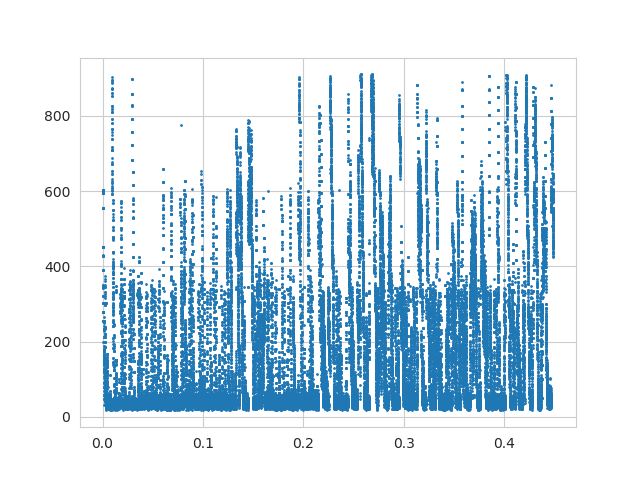

0.5062
0.50976
0.7210988622295584
0.7026126714565644
0.9969727547931383
0.6703786191536748
0.6984900146127618
0.7292703150912107
0.859025787965616


In [316]:
plt.figure()
for x in upset_mcd_only[2:3]:
    plot_timeseries(x[0])
for x in booster_misses_50_50:
    print(sum(x[0][:,1] > 30e-6) / len(x[0]))

In [219]:
def plot_success(experiments, full_exp, color=None, label=None, **kwargs):
    values = sorted(experiments, key=lambda x: x[1])
    keys = []
    y = []
    for val, exp in zip(values, full_exp):
        #keys.append(apparent_rate(exp) / 1000)
        keys.append(val[2] / 1000)
        y.append(val[0])
        
    print(keys, y)
    plt.plot(keys, y, '.-', color=color, label=label, **kwargs)

In [68]:
upset_booster_only[0]

(array([[1.54845209e+09, 1.94072723e-04],
        [1.54845213e+09, 5.00679016e-05],
        [1.54845213e+09, 9.05990601e-06],
        ...,
        [1.54845213e+09, 1.00135803e-05],
        [1.54845209e+09, 1.00135803e-05],
        [1.54845213e+09, 9.05990601e-06]]), 3748.4737073166343, 163304)

<IPython.core.display.Javascript object>


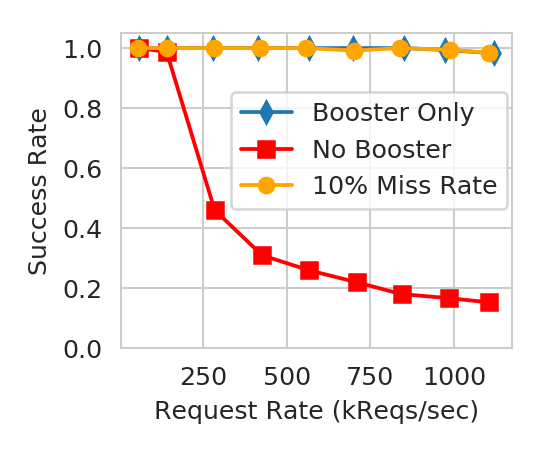

[56.67096149356208, 140.19782705775702, 279.3811164310018, 414.129541864139, 565.7061778082295, 698.284880913931, 851.4105921279662, 971.9325703915008, 1119.7155498684187] [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9938750100409671, 0.9828148088172783]
[56.6608100692768, 140.45463282515703, 284.0214632613648, 426.1378091154776, 567.6262653602555, 709.2712656040205, 843.0863487800858, 984.3288555952951, 1104.6828415208436] [1.0, 0.9876, 0.46008, 0.3092, 0.2588, 0.21928, 0.17976, 0.1664, 0.15232]
[55.72260497183914, 140.15856753221843, 280.7849626919127, 421.052293434309, 558.7845651281887, 701.0767785566956, 838.8171780169845, 989.0186346243981, 1104.556724764436] [1.0, 1.0, 1.0, 1.0, 1.0, 0.99164, 0.999979998399872, 0.9943179536602016, 0.9842033939442972]


In [264]:
%matplotlib notebook
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize=(3,2.5))
plot_success(upset_booster_only_success, upset_booster_only, label='Booster Only', marker='d')
plot_success(upset_mcd_only_success, upset_mcd_only, color='red', label='No Booster', marker='s')
plot_success(booster_misses_90_10_success, booster_misses_90_10, color='orange', label='10% Miss Rate', marker='o')
plt.ylim([0,1.05])
plt.ylabel("Success Rate")
plt.xlabel("Request Rate (kReqs/sec)")
plt.legend(bbox_to_anchor=(.25,.4, .1, .1))
plt.tight_layout()
plt.savefig("mcd_success.pdf")



In [270]:
cols = ["#9c2b2a",
"#3d8500",
"#0086b3"]
def plot_experiments(experiments, successes, threshold=None, color=None, label=None, marker=None):
    try:
        values = experiments.values
    except:
        values = experiments
    values = sorted(values, key = lambda x: x[1])
    keys = []
    sub, sup = [], []
    no = []
    for vals, succ in zip(values, successes):
        if len(vals[0]) == 0:
            continue
        keys.append(succ[2] / 1000)
        val = vals[0]
#       keys.append(apparent_rate(vals) / 1000)
#         keys.append(apparent_rate(vals) / 1000)
    
        if threshold is not None:
            low = val[val[:,1] < threshold,1]
            high = val[val[:,1] > threshold,1]
            print('HIT RATE: ', float(len(low)) / float(len(high) + len(low)))
            sub.append([np.percentile(low, x) * 1000000 for x in (10, 50, 99)])
            sup.append([np.percentile(high, x) * 1000000 for x in (10, 50, 99)])
            print(float(len(high)) / len(low))
            #_, lowdiffs = filter_tds(low, 90).T
            #_, hidiffs = filter_tds(high, 90).T
            #sub.append(lowdiffs.mean() * 1000)
            #sup.append(hidiffs.mean() * 1000)
        else:
            no.append([np.percentile(val[:,1], x) * 1000000 for x in (10, 50, 90)])
    if no:
        print(keys)
        low, med, high = zip(*no)
        plt.fill_between(keys, low, high, label=label or 'No Booster', alpha=.2, color=color or cols[2])
        plt.plot(keys, med, marker, color=color or cols[2])
        #print('no', no)
    if sub:
        #print(sub)
        low, med, high = zip(*sub)
        plt.fill_between(keys, low, high, label='Booster Hits', color=cols[0], alpha=.5)
        plt.plot(keys, med, marker, color=cols[0])
    if sup:
        low, med, high = zip(*sup)
        plt.fill_between(keys, low, high, label='Booster Misses', alpha=.2, color=cols[1])
        plt.plot(keys, med, marker, color=color or cols[1])
        #print(sup)
    keys

In [272]:
plt.figure(figsize=(3,2.5))

plot_experiments(upset_booster_only, upset_booster_only_success, label='Booster Only', marker='d-')
plot_experiments(upset_mcd_only, upset_mcd_only_success,  color='red', label='No Booster', marker='s-')
plot_experiments(booster_misses_90_10, booster_misses_90_10_success, color='orange', label='10% Miss Rate', marker='o-')
# plot_experiments(booster_misses_50_50, booster_misses_50_50_success, color='green', label='50% Collision')

plt.ylabel("Latency (μs)")
plt.xlabel("Request Rate (kReqs/sec)")
plt.yscale("log")
plt.legend(bbox_to_anchor=(.25, .4, .1, .1))
plt.tight_layout()
plt.savefig("mcd_latency.pdf")

#plot_experiments(pre_tds, None, color='green')

<IPython.core.display.Javascript object>

[56.67096149356208, 140.19782705775702, 279.3811164310018, 414.129541864139, 565.7061778082295, 698.284880913931, 851.4105921279662, 971.9325703915008, 1119.7155498684187]
[56.6608100692768, 140.45463282515703, 284.0214632613648, 426.1378091154776, 567.6262653602555, 709.2712656040205, 843.0863487800858, 984.3288555952951, 1104.6828415208436]
[55.72260497183914, 140.15856753221843, 280.7849626919127, 421.052293434309, 558.7845651281887, 701.0767785566956, 838.8171780169845, 989.0186346243981, 1104.556724764436]


<IPython.core.display.Javascript object>


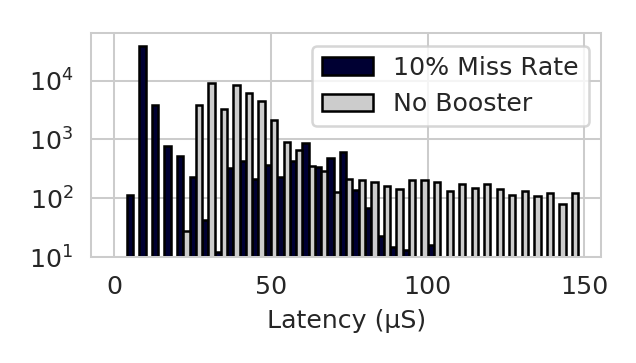

In [248]:
def make_hist(experiments, **kwargs):
    data = []
    for exp in experiments:
        data.append(exp[0][:,1] * 1e6)
    
    plt.hist(data, np.arange(0, 150, 4), histtype='bar', **kwargs)
    plt.yscale('log')
    plt.ylim([10,None])
    
plt.figure(figsize=(3.5, 2))

make_hist([booster_misses_90_10[0], upset_mcd_only[0]], color=[[0, 0, .2], [.8,.8,.8]], edgecolor='black', rwidth=1)
plt.legend(['10% Miss Rate', 'No Booster'])
plt.xlabel("Latency (μS)")
plt.tight_layout()
plt.savefig("mcd_hist.pdf")
